# Capstone Project: Battle of the Neighborhoods - Vegetarian/Vegan Restaurants Edition

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* Introduction
* Part 1: Vegetarian/vegan friendly neighborhoods 
* Part 2: Categorizing vegetarian/vegan restaurants


## Introduction

Interest in vegetarian and vegan foods have been growing rapidly in recent years, and it is now easier than ever to find vegetarian and vegan foods when dining out. Many places not only offer salads and soups that are vegetarian or vegan, but foods that are traditionally non-vegetarian such as burgers and pizzas have vegetarian and vegan variations as well. However, not all places in the U.S. are equally vegetarian and vegan friendly (ie. restaurants don’t have many items for vegetarian or vegans to choose from). Generally, cities are better compared to rural areas, and within cities some neighborhoods are better than others. This project uses **Foursquare location data** to find the number of vegetarian/vegan food places in each neighborhood of **New York City** (all five boroughs) and show this visually on a map, so vegetarians and vegans know which neighborhoods to visit the next time they dine out, and tourists can likewise know which neighborhoods to book their stay for the optimal food experience. The project will also identify the different **categories of vegetarian/vegan food places** (such as Italian restaurants, coffee shops, bars, etc.) in NYC and mark them clearly on a map for easy viewing, because currently there are **two main inconveniences** with using Foursquare for vegetarian/vegan searches: 1) search results sometimes return places that have only 1 or 2 items that are vegetarian or vegan, which is not ideal for people who want a variety of items to choose from; 2) the category of vegetarian/vegan restaurant is not specified on the search page, and users sometimes have to dig through photos and tips to understand the types of foods offered at the place. Hence this project seeks to address these issues and **make Foursquare location data more useful to vegetarians, vegans, and anyone interested in vegetarian and vegan food.**


## Part 1: Vegetarian/vegan friendly neighborhoods
We will use Foursquare's **Places API** to get each neighborhood's venues with the category tag "Vegetarian/Vegan", so we can store them in a dataframe and count and analyze them later. This can be achieved with the **search endpoint**, which takes in a coordinate location, and optionally a search term and radius, and returns a list of matching venues near that location. The coordinates for each neighborhood are from the json file here: https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json

To get the subcategories of vegan/vegetarian restaurants, we will use Places API again but with the **details endpoint**. These requests require a venue ID which is included in the response by the API calls above. 

In [71]:
# import all libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Neighborhoods coordinates data:

In [72]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json"
r = requests.get(url)
len(r.json()['features'])  #306 neighborhoods included

newyork_data = r.json()
neighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)


In [73]:
# put neighborhoods data into dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)
neighborhoods.head()

The dataframe has 5 boroughs and 306 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


API calls to get vegetarian/vegan venues:

In [86]:
# API credentials
cred = pd.read_csv('foursq_api_cred.csv')
CLIENT_ID = cred.loc[0,'Client_Id']
CLIENT_SECRET = cred.loc[0,'Client_Secret']
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


Let's try the first neighborhood in Neighborhoods dataframe: Wakefield

In [89]:
# let's try the first neighborhood in Neighborhoods dataframe: Wakefield
neighborhood_latitude = neighborhoods.loc[0,'Latitude']
neighborhood_longitude = neighborhoods.loc[0,'Longitude']
neighborhood_name = neighborhoods.loc[0, 'Neighborhood']

# get all vegetarian/vegan restaurants in the neighborhood
radius = 500 # using a radiums of 500 meters around each neighborhood coordinate
url = 'https://api.foursquare.com/v2/venues/search?client_id='+CLIENT_ID+\
'&client_secret='+CLIENT_SECRET+'&v='+VERSION+'&ll='+str(neighborhood_latitude)+','+\
str(neighborhood_longitude)+'&radius='+str(radius)+'&categoryId=4bf58dd8d48988d1d3941735'
url
results = requests.get(url).json()
results # returns empty venues, no vegetarian/vegan restaurants in wakefield
# len(results['response']['venues']) is 0

{'meta': {'code': 200, 'requestId': '5ff6bddd0643d9710171f860'},
 'response': {'venues': []}}

No venues were returned in the response. There are probably no vegetarian/vegan restaurants in Wakefiled. 

Let's try another neighborhood to see if it returns anything for venues. Using East Village because I've been to vegetarian/vegan restaurants there

In [91]:
idx = list(neighborhoods['Neighborhood']).index('East Village')
n_lat = neighborhoods.loc[idx,'Latitude']
n_long = neighborhoods.loc[idx,'Longitude']
n_name = neighborhoods.loc[idx,'Neighborhood']
n_name
url = 'https://api.foursquare.com/v2/venues/search?client_id='+CLIENT_ID+\
'&client_secret='+CLIENT_SECRET+'&v='+VERSION+'&ll='+str(n_lat)+','+\
str(n_long)+'&radius='+str(radius)+'&categoryId=4bf58dd8d48988d1d3941735'
url
results = requests.get(url).json()
results # indeed it returns a bunch of venues
results['response']['venues'][0] # sample response for a venue

{'id': '549c6881498eaaf3954382f3',
 'name': 'Superiority Burger',
 'location': {'address': '430 E 9th St',
  'crossStreet': 'btwn 1st Ave & Ave A',
  'lat': 40.72754947104763,
  'lng': -73.9832897923765,
  'labeledLatLngs': [{'label': 'display',
    'lat': 40.72754947104763,
    'lng': -73.9832897923765},
   {'label': 'entrance', 'lat': 40.727506, 'lng': -73.983462}],
  'distance': 95,
  'postalCode': '10009',
  'cc': 'US',
  'city': 'New York',
  'state': 'NY',
  'country': 'United States',
  'formattedAddress': ['430 E 9th St (btwn 1st Ave & Ave A)',
   'New York, NY 10009',
   'United States']},
 'categories': [{'id': '4bf58dd8d48988d1d3941735',
   'name': 'Vegetarian / Vegan Restaurant',
   'pluralName': 'Vegetarian / Vegan Restaurants',
   'shortName': 'Vegetarian / Vegan',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1610006123',
 'hasPerk': False}

Indeed a bunch of venues are returned for East Village.

Now we repeat the calls for for all neighborhoods in NYC and collect the name, address, latitude, and longitude for each venue, and put them into a dataframe for further analysis.

This part is commented out because I've run the calls before and have stored the results in a csv file. Foursquare API limits the number of calls you can make on a personal account each day so I will import the data from the csv file instead. But the code below is exactly what I did to get the venues data into the dataframe.

In [ ]:
# now we repeat for all neighborhoods in nyc
# this part is commented out because i've run the calls before and have stored the results \
# in a csv file. foursquare api has day and hour quotas on the number of calls so i will \
# import data from the csv file instead to conserve 

# veg_food = col_names = ['Name','Address','Neighborhood','Latitude','Longitude']
# veg_food = pd.DataFrame(columns=col_names)
# for i in range(0,neighborhoods.shape[0]):
#     neighborhood_latitude = neighborhoods.loc[i,'Latitude']
#     neighborhood_longitude = neighborhoods.loc[i,'Longitude']
#     neighborhood_name = neighborhoods.loc[i, 'Neighborhood']
#     url = 'https://api.foursquare.com/v2/venues/search?client_id='+CLIENT_ID+\
#     '&client_secret='+CLIENT_SECRET+'&v='+VERSION+'&ll='+str(neighborhood_latitude)+','+\
#     str(neighborhood_longitude)+'&radius='+str(radius)+'&categoryId=4bf58dd8d48988d1d3941735'
#     results = requests.get(url).json()
#     venues = results['response']['venues']
#     if len(venues) > 0:
#         for v in venues:
#             name = v['name']
#             address = v['location']['formattedAddress']
#             neighborhood = neighborhood_name
#             lat = v['location']['lat']
#             lng = v['location']['lng']
#             ven_id = v['id']
            
#             veg_food = veg_food.append({'Name':name,
#                                 'Address':address,
#                                'Neighborhood':neighborhood,
#                                'Latitude':lat,'Longitude':lng,'Id':ven_id}, ignore_index=True)
#     else:
#         neighborhood = neighborhood_name
#         veg_food = veg_food.append({'Neighborhood':neighborhood},ignore_index=True)

# veg_food

In [93]:
veg_food = pd.read_csv('veg_food.csv') # importing from file
print(veg_food.shape)
veg_food.head(15)

(643, 6)


,Name,Address,Neighborhood,Latitude,Longitude,Id
0,NaN,NaN,Wakefield,NaN,NaN,NaN
1,NaN,NaN,Co-op City,NaN,NaN,NaN
2,NaN,NaN,Eastchester,NaN,NaN,NaN
3,NaN,NaN,Fieldston,NaN,NaN,NaN
4,NaN,NaN,Riverdale,NaN,NaN,NaN
5,Kingsbridge-Riverdale Farmers' Market,"['260 W 231st St (Kingsbridge Ave.)', 'Bronx, ...",Kingsbridge,40.879973,-73.907295,52411ca98bbd75ed0f690c1f
6,Kingsbridge-Riverdale Farmers' Market,"['260 W 231st St (Kingsbridge Ave.)', 'Bronx, ...",Marble Hill,40.879973,-73.907295,52411ca98bbd75ed0f690c1f
7,NaN,NaN,Woodlawn,NaN,NaN,NaN
8,NaN,NaN,Norwood,NaN,NaN,NaN
9,NaN,NaN,Williamsbridge,NaN,NaN,NaN


The first rows of the veg_food dataframe are for neighborhoods in Bronx, and there don't seem to be many vegan/vegetarian food places there (NaN means no venues were returned), but some other neighborhoods in other boroughs are more populated with vegetarian/vegan places.

It also seems that some places were picked up more than once, for example the Kingsbridge-Riverdale Farmers' Market in the above dataframe appear in two rows for different neighborhoods but their coordinates and venue ID are the same. This is possible when venues in a neighborhood are also within 500 meters of another neighborhood's coordinates. It shows a drawback with using a fixed radius for all the neighborhoods. Let's see how many duplicates there are:

In [94]:
veg_food_rep = pd.DataFrame(veg_food.groupby('Id').size())
len(veg_food_rep[veg_food_rep[0]>1]) # 85 venues were picked up more than once

85

85 venues were picked up more than once, mostly twice and very rarely three times. While this is not ideal, there is also no easy fix for this problem given our neighborhoods coordinates, since we would have to go through each neighborhood and calculate the appropriate radius to enter into the API call if we want to be accurate. This would be very time consuming and was not included in this project. However, it would make for more accurate results. 

Since the number of repeats is relatively small compared to the total number of venues, we will keep the repeats for now. Note that the total count of vegetarian/vegan places in NYC would be about 90 higher than if the repeated rows were removed. 

Next we plot all these restaurants on a map to get an initial idea of the distribution:

In [121]:
# make a map of these vegetarian/vegan food places
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_ny_vegfood = folium.Map(location=[latitude, longitude], zoom_start=10)

veg_food2 = veg_food.dropna()
for lat, lng, name in zip(veg_food2['Latitude'], veg_food2['Longitude'], veg_food2['Name']):
    label = name
    label = folium.Popup(label, parse_html=True) # the name of the restaurant shows when clicked
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny_vegfood) 
    
map_ny_vegfood

As expected, Manhattan has higher number and higher concentration of vegetarian/vegan food places compared to other boroughs. There are big variations between neighborhoods too, for instance the southern part of Manhattan has a lot more restaurants compared to the North.

Now we can group the veg_food dataframe from above by neighborhood to get the number of vegetarian/vegan places in each neighborhood. 

In [99]:
# get the number of vegan/vegetarian food places in each neighborhood
veg_nb_count = pd.DataFrame(veg_food.groupby('Neighborhood').count()) 
veg_nb_count = veg_nb_count.iloc[:,0] # only need 1 column for the count
veg_nb_count.head(10)  # the neighborhoods with 0 have no food places listed as vegan/vegetarian

Neighborhood
Allerton           0
Annadale           0
Arden Heights      0
Arlington          0
Arrochar           0
Arverne            0
Astoria            1
Astoria Heights    0
Auburndale         0
Bath Beach         0
Name: Name, dtype: int64

In [101]:
# add borough and coordinates back to the dataframe
veg_nb_b_count = neighborhoods.set_index('Neighborhood').join(veg_nb_count)
veg_nb_b_count = veg_nb_b_count.rename(columns={"Name":"Count"})
veg_nb_b_count.head(10)

,Borough,Latitude,Longitude,Count
Neighborhood,,,,
Allerton,Bronx,40.865788,-73.859319,0
Annadale,Staten Island,40.538114,-74.178549,0
Arden Heights,Staten Island,40.549286,-74.185887,0
Arlington,Staten Island,40.635325,-74.165104,0
Arrochar,Staten Island,40.596313,-74.067124,0
Arverne,Queens,40.589144,-73.791992,0
Astoria,Queens,40.768509,-73.915654,1
Astoria Heights,Queens,40.770317,-73.894680,0
Auburndale,Queens,40.761730,-73.791762,0


In [106]:
# sort the rows in descending order of number of vegetarian/vegan venues
result_df_sorted = veg_nb_b_count.sort_values(by='Count', ascending=False)
print(result_df_sorted.shape)
result_df_sorted

(306, 4)


,Borough,Latitude,Longitude,Count
Neighborhood,,,,
Noho,Manhattan,40.723259,-73.988434,28
Greenwich Village,Manhattan,40.726933,-73.999914,27
Flatiron,Manhattan,40.739673,-73.990947,23
East Village,Manhattan,40.727847,-73.982226,21
Little Italy,Manhattan,40.719324,-73.997305,21
Soho,Manhattan,40.722184,-74.000657,21
Chinatown,Manhattan,40.715618,-73.994279,18
Midtown,Manhattan,40.754691,-73.981669,14
North Side,Brooklyn,40.714823,-73.958809,13


The neighborhoods at the top of the above data frame have the highest number of vegetarian/vegan restaurants. Most of them are from Manhattan. We also have a bunch of neighborhoods at the bottom that don't have any vegetarian/vegan restaurants at all. 

To see the results for each borough separately, we can make a dataframe for each borough.

In [108]:
# make separate dataframes for each borough
brooklyn = result_df_sorted[(result_df_sorted['Borough']=='Brooklyn')]
manhattan = result_df_sorted[(result_df_sorted['Borough']=='Manhattan')]
staten_island = result_df_sorted[(result_df_sorted['Borough']=='Staten Island')]
queens = result_df_sorted[(result_df_sorted['Borough']=='Queens')]
bronx = result_df_sorted[(result_df_sorted['Borough']=='Bronx')]
print(brooklyn.head(10),staten_island.head(10))

                            Borough   Latitude  Longitude  Count
Neighborhood                                                    
North Side                 Brooklyn  40.714823 -73.958809     13
South Side                 Brooklyn  40.710861 -73.958001     11
Dumbo                      Brooklyn  40.703176 -73.988753      7
Downtown                   Brooklyn  40.690844 -73.983463      7
Prospect Heights           Brooklyn  40.676822 -73.964859      5
East Williamsburg          Brooklyn  40.708492 -73.938858      5
Boerum Hill                Brooklyn  40.685683 -73.983748      4
Prospect Lefferts Gardens  Brooklyn  40.658420 -73.954899      4
Greenpoint                 Brooklyn  40.730201 -73.954241      4
Fort Greene                Brooklyn  40.688527 -73.972906      4                        Borough   Latitude  Longitude  Count
Neighborhood                                               
Chelsea          Staten Island  40.594726 -74.189560      6
Bay Terrace      Staten Island  40.55398

We've now done all the data collection and processing for part 1. I have summarized the **results** in a table below, ranking the most vegetarian/vegan friendly neighborhoods in each borough

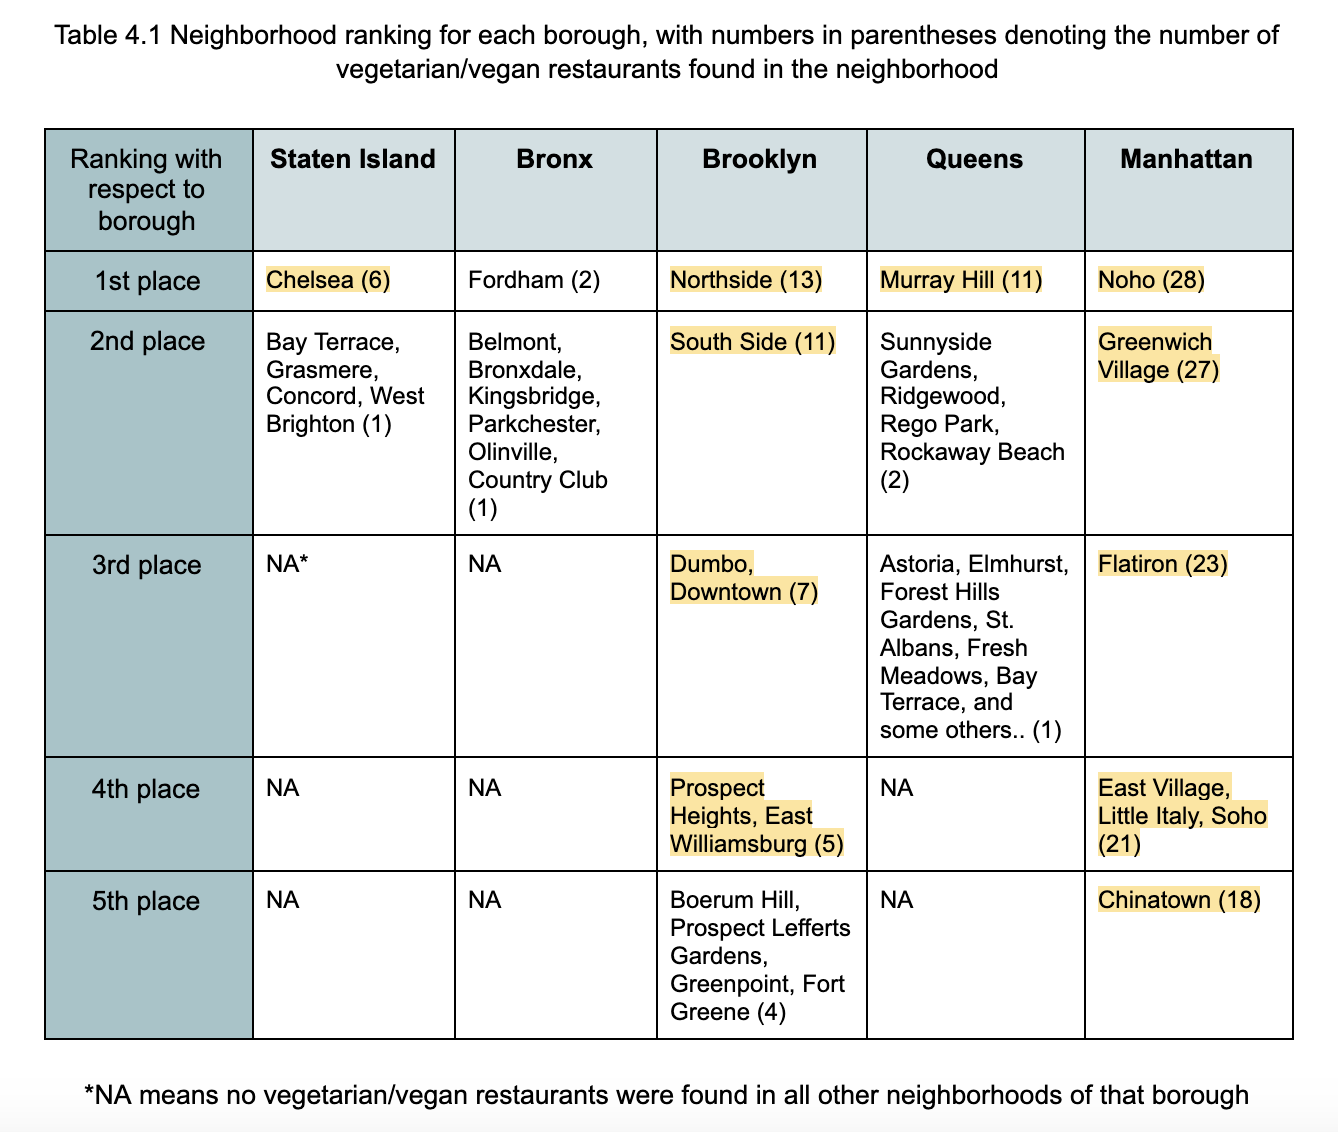

In [183]:
from IPython.display import Image
Image(filename='table1.png') 

As the table shows, vegetarian/vegan food places are common in many neighborhoods of Manhattan and Brooklyn, Murray Hill of Queens, and Chelsea of Staten Island, but not so much in other areas. Therefore, those seeking for a rich vegetarian or vegan dining experience should consider visiting the neighborhoods that are highlighted above. Since Manhattan is exceptionally good for vegetarian/vegan food compared to other boroughs, there are additional neighborhoods that didn’t fit into the table. These are shown in the table below, taken from the Manhattan data frame, sorted by the count of vegetarian/vegan restaurants in descending order:

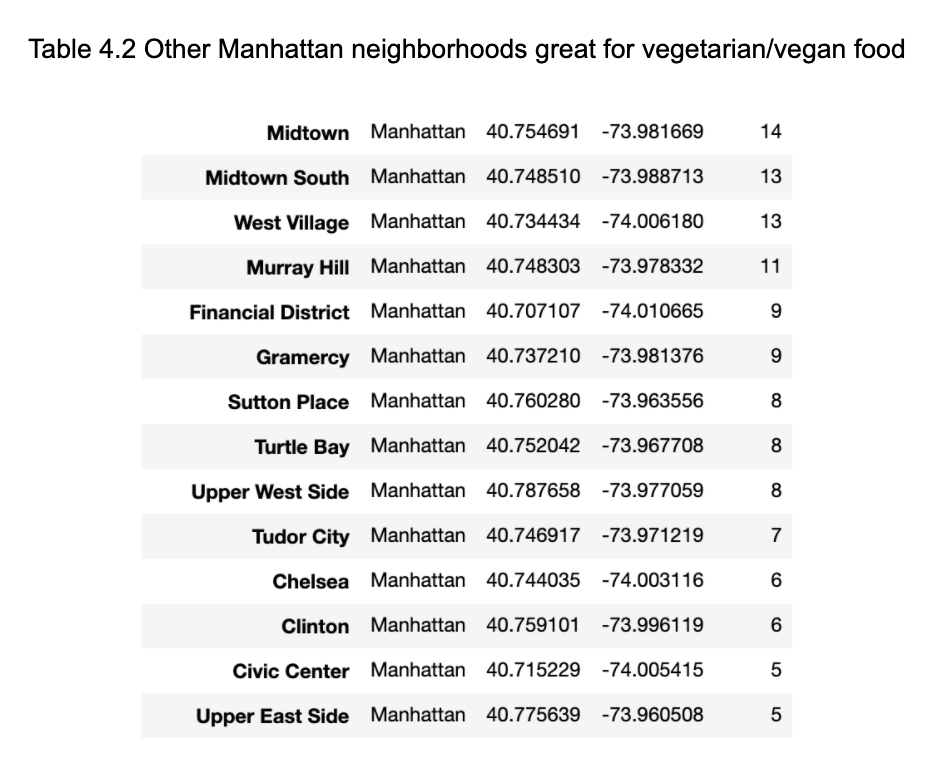

In [185]:
Image(filename='table2.png') 

As previously mentioned, there are some possible inaccuracies in these counts, namely, some restaurants could be counted more than once if they are within 500 meters from another neighborhood’s coordinates. This issue could be alleviated by determining an appropriate radius for each neighborhood (very time consuming), or resolved entirely with a geoJson file that outlines the coordinates of each neighborhood, however, the files I managed to find either had several neighborhoods grouped together, or they were outlined by zip code rather than neighborhood (zip codes in NYC do not translate 1-1 with neighborhoods). Realistically speaking though, people don’t usually think strictly in terms of neighborhoods, so a map was also used to show the distribution of vegetarian/vegan restaurants (each restaurant shows up on the map only once).

We've now seen how neighborhoods compare in terms of their vegetarian/vegan restaurant counts. We can move on to part 2

## Part 2: Categorizing vegan/vegetarian restaurants

In part 2 we will categorize the vegetarian/vegan food places further so it's easier for people to find the food they want. There are several ways to get labels in addition to vegetarian/vegan. I initially thought of using Foursquare's Places API with details endpoint to retrieve the tips and description of each restaurant, then do some text mining and topic analysis on that to identify the different types of restaurants. I also thought about doing text clustering, an unsupervised machine learning algorithm for text data, but both these methods are rather complicated and don't seem to necessairly warrant good results. Then, I saw that the response for the details endpoint already include a field called categories that have labels for the restaurants (a bit hard to find, in the last portion of the response). Some only have vegetarian/vegan, while many others have more informative subcategories as well. So we will aim for the simplest approach and make the API calls that collect this category information for each venue and store them in a dataframe.

To illustrate this we will test it on one of the venues, Superiority Burger

In [110]:
v_id = '549c6881498eaaf3954382f3' # venue id of superiority burger
url = 'https://api.foursquare.com/v2/venues/'+v_id+'?'+'&client_id='+CLIENT_ID+\
'&client_secret='+CLIENT_SECRET+'&v='+VERSION
results = requests.get(url).json()
results
results['response']['venue']['categories']

[{'id': '4bf58dd8d48988d1d3941735',
  'name': 'Vegetarian / Vegan Restaurant',
  'pluralName': 'Vegetarian / Vegan Restaurants',
  'shortName': 'Vegetarian / Vegan',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_',
   'suffix': '.png'},
  'primary': True},
 {'id': '4bf58dd8d48988d16c941735',
  'name': 'Burger Joint',
  'pluralName': 'Burger Joints',
  'shortName': 'Burgers',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/burger_',
   'suffix': '.png'}}]

The above response shows that Superiority Burger has two labels: vegetarian/vegan and burger joint. The additional label burger joint is useful for filtering search results for people looking to have a particular kind of vegan/vegetarian food. 

Now we can repeat the API call for each food place and collect their categories. The cell below contains the code for how I did this, but is commented out because I don't want to run out of calls. I will import the csv file I made previously instead. 

In [ ]:
# api calls to get categories for each food place

# col_names = ['Id','Name','Category']
# veg_food_cat = pd.DataFrame(columns=col_names)

# for i in range(0,veg_food.dropna().shape[0]):
#     v_id = veg_food3.loc[i,'Id']
#     url = 'https://api.foursquare.com/v2/venues/'+v_id+'?'+'&client_id='+CLIENT_ID+\
#    '&client_secret='+CLIENT_SECRET+'&v='+VERSION
#     results = requests.get(url).json()
    
#     try:
#         name = results['response']['venue']['name']
#         cats = results['response']['venue']['categories']
#         print(name,cats)
#         if len(cats) > 0:
#             for c in cats:
#                 cat = c['name']
#                 if cat != 'Vegetarian / Vegan Restaurant':
#                     veg_food_cat = veg_food_cat.append({'Id':v_id,'Name':name,'Category':cat},ignore_index=True)
#                 else:
#                     veg_food_cat = veg_food_cat.append({'Id':v_id,'Name':name,'Category':'Vegetarian / Vegan Restaurant'},ignore_index=True)

#     except KeyError:
#         name = veg_food3.loc[i,'Name']
#         veg_food_cat = veg_food_cat.append({'Id':v_id,'Name':name,'Category':'Vegetarian / Vegan Restaurant'},ignore_index=True)
    
# veg_food_cat

In [128]:
veg_food_cat = pd.read_csv('veg_food_cat_all.csv') # importing file
veg_food_cat.head(10)
# veg_food_cat.shape # 564 rows

,Id,Name,Category
0,52411ca98bbd75ed0f690c1f,Kingsbridge-Riverdale Farmers' Market,Vegetarian / Vegan Restaurant
1,4f5e4764e4b035e316230d07,Veggie Mart,Vegetarian / Vegan Restaurant
2,4c48c2889e3e2d7f412add47,C. Kim's Fruit & Vegetable,Vegetarian / Vegan Restaurant
3,4ec9bdfb4690116a8ecd9656,Vegetarian Joint,Vegetarian / Vegan Restaurant
4,5c371f9adee770002b4c3c39,Tandoori Place,Indian Restaurant
5,5c371f9adee770002b4c3c39,Tandoori Place,Vegetarian / Vegan Restaurant
6,50929626e4b0948956a54115,Touch A Life Health Food Services,Vegetarian / Vegan Restaurant
7,4ff37cb9e4b0b8fda883be7f,Adelina's,Italian Restaurant
8,4ff37cb9e4b0b8fda883be7f,Adelina's,Wine Bar
9,4ff37cb9e4b0b8fda883be7f,Adelina's,Vegetarian / Vegan Restaurant


the dataframe veg_food_cat has at least one category for each place. we can put all the unique categories into a list

In [134]:
all_cats = list(veg_food_cat.Category.unique())
all_cats

['Vegetarian / Vegan Restaurant',
 'Indian Restaurant',
 'Italian Restaurant',
 'Wine Bar',
 'Buffet',
 'Pizza Place',
 'Juice Bar',
 'Café',
 'Coffee Shop',
 'Burger Joint',
 'Falafel Restaurant',
 'Flower Shop',
 'Bakery',
 'French Restaurant',
 'Temple',
 'Deli / Bodega',
 'Food Court',
 'American Restaurant',
 'Salad Place',
 'Restaurant',
 'Theme Restaurant',
 'Creperie',
 'Food & Drink Shop',
 'Sushi Restaurant',
 'Chinese Restaurant',
 'Dim Sum Restaurant',
 'Grocery Store',
 'Mediterranean Restaurant',
 'Mexican Restaurant',
 'Lounge',
 'Gluten-free Restaurant',
 'New American Restaurant',
 'Food Truck',
 'Fast Food Restaurant',
 'BBQ Joint',
 'Japanese Restaurant',
 'Korean Restaurant',
 'Kosher Restaurant',
 'Ice Cream Shop',
 'Pop-Up Shop',
 'Breakfast Spot',
 'Turkish Restaurant',
 'Filipino Restaurant',
 'Mac & Cheese Joint',
 'Noodle House',
 'Szechuan Restaurant',
 'Thai Restaurant',
 'Asian Restaurant',
 'Health Food Store',
 'Moving Target',
 'Latin American Restaurant

We can also group by category and see how many venues there are for each

In [144]:
veg_food_cat.groupby('Category').count()

,Id,Name
Category,,
American Restaurant,6,6
Asian Restaurant,3,3
BBQ Joint,1,1
Bagel Shop,1,1
Bakery,11,11
Breakfast Spot,1,1
Buffet,1,1
Burger Joint,7,7
Café,18,18


Now we need to put categories with the rest of venue information, so we can show them on a map

In [131]:
# this cleans up previous dataframe veg_food by dropping duplicate rows and rows with NaNs
veg_food2 = veg_food.dropna().drop_duplicates(subset=['Id'])
veg_food2
# veg_food2.shape # 324 rows

,Name,Address,Neighborhood,Latitude,Longitude,Id
5,Kingsbridge-Riverdale Farmers' Market,"['260 W 231st St (Kingsbridge Ave.)', 'Bronx, ...",Kingsbridge,40.879973,-73.907295,52411ca98bbd75ed0f690c1f
16,Veggie Mart,"['New York', 'United States']",Fordham,40.861740,-73.890566,4f5e4764e4b035e316230d07
17,C. Kim's Fruit & Vegetable,"['E. Kingsbridge Road', 'Bronx, NY', 'United S...",Fordham,40.864635,-73.891895,4c48c2889e3e2d7f412add47
30,Vegetarian Joint,"['Bronx, NY 10469', 'United States']",Country Club,40.842828,-73.825764,4ec9bdfb4690116a8ecd9656
31,Tandoori Place,"['2146 Starling Ave', 'Bronx, NY 10462', 'Unit...",Parkchester,40.836010,-73.853482,5c371f9adee770002b4c3c39
42,Touch A Life Health Food Services,"['753 Burke Ave (Holland Ave)', 'Bronx, NY 104...",Olinville,40.871552,-73.864937,50929626e4b0948956a54115
50,Adelina's,"['159 Greenpoint Ave (at Leonard St.)', 'Brook...",Greenpoint,40.730301,-73.953352,4ff37cb9e4b0b8fda883be7f
51,Jungle Cafe,"['131 Greenpoint Ave (at Huron St)', 'Brooklyn...",Greenpoint,40.730201,-73.954761,53dd1ead498e9ef3f539fb4e
52,Acai Berry,"['650 Manhattan Ave (Bedford)', 'Brooklyn, NY ...",Greenpoint,40.724281,-73.951110,56d33e10cd101bd7e405d48d
53,Paulie Gee’s,['60 Greenpoint Ave (btwn Franklin St & West S...,Greenpoint,40.729801,-73.958520,4b9709fcf964a520c4f434e3


In [130]:
# join veg_food2 and veg_food_cat so we have a dataframe that contains all the info for each venue
df_all = veg_food_cat.set_index('Id').join(veg_food2.set_index('Id'),lsuffix='_c').drop(['Name_c'],axis=1)
df_all
# df_all.shape # 564 rows

,Category,Name,Address,Neighborhood,Latitude,Longitude
Id,,,,,,
3fd66200f964a52015e71ee3,Health Food Store,Lifethyme Natural Market,['410 Avenue of the Americas (btw 8th and 9th ...,West Village,40.733860,-73.999375
3fd66200f964a52015e71ee3,Vegetarian / Vegan Restaurant,Lifethyme Natural Market,['410 Avenue of the Americas (btw 8th and 9th ...,West Village,40.733860,-73.999375
3fd66200f964a5204ce51ee3,Vegetarian / Vegan Restaurant,Stingy Lulu's,['129 Saint Marks Pl (btw Avenue A and First A...,East Village,40.726788,-73.983622
3fd66200f964a52056ee1ee3,Pizza Place,Vinnie's Pizzeria,"['148 Bedford Ave (at N 9th St)', 'Brooklyn, N...",North Side,40.718849,-73.956643
3fd66200f964a52056ee1ee3,Vegetarian / Vegan Restaurant,Vinnie's Pizzeria,"['148 Bedford Ave (at N 9th St)', 'Brooklyn, N...",North Side,40.718849,-73.956643
3fd66200f964a52088e91ee3,Vegetarian / Vegan Restaurant,Candle Cafe,"['1307 3rd Ave (btwn 74th & 75th St.)', 'New Y...",Upper East Side,40.771407,-73.959138
3fd66200f964a52088e91ee3,Gluten-free Restaurant,Candle Cafe,"['1307 3rd Ave (btwn 74th & 75th St.)', 'New Y...",Upper East Side,40.771407,-73.959138
3fd66200f964a52088e91ee3,Juice Bar,Candle Cafe,"['1307 3rd Ave (btwn 74th & 75th St.)', 'New Y...",Upper East Side,40.771407,-73.959138
3fd66200f964a520b1e91ee3,Vegetarian / Vegan Restaurant,Hangawi,"['12 E 32nd St (btwn Madison & 5th Ave)', 'New...",Midtown South,40.746927,-73.984779


In [147]:
# make separate dataframes for the categories and put in a dictionary. this is useful for \
# creating the layered map
d = {}
for c in all_cats:
    df_c = df_all.copy()
    df_c = df_c[df_c.Category==c]
    d["{}".format(c)] = df_c

d['Asian Restaurant'] # there are 3 restaurants with the category asian restaurant, which \
# matches the count we have before

,Category,Name,Address,Neighborhood,Latitude,Longitude
Id,,,,,,
4a75edcff964a520b3e11fe3,Asian Restaurant,Wild Ginger Vegetarian Kitchen,"['380 Broome St (at Mulberry St.)', 'New York,...",Little Italy,40.720431,-73.996640
4d2ba0e26e27a14319873924,Asian Restaurant,Boon Sik Zip,"['11 W 32nd St', 'New York, NY 10001', 'United...",Midtown South,40.747699,-73.986236
50eb4bd4805574af86384d43,Asian Restaurant,Green Fusion,"['547 Avenue of the Americas', 'New York, NY 1...",Flatiron,40.738056,-73.996803


Now we have all the info we need for the map. Note that for this first map we are only plotting the venues that have categories in addition to vegetarian/vegan, for clarity

In [151]:
# map with layers
from folium import FeatureGroup, LayerControl, Map, Marker
ny_lat = 40.7127281
ny_lon = -74.0060152
map_ny_veg_lay = folium.Map(location=[ny_lat, ny_lon], zoom_start=10)

d_fg = {} #dictionary for feature groups
for c in all_cats[1:]: # omitting vegetarian/vegan category for clarity
    d_fg["{}".format(c)] = FeatureGroup(name="{}".format(c))
    df = d["{}".format(c)]  #dataframe for the category
    for name,address,lat,lng,cat in zip(df['Name'],df['Address'],df['Latitude'],df['Longitude'],df['Category']):
        text = name+'\n('+cat+')\n'+address
        icon = folium.Icon(color="green",prefix="fa",icon="leaf")
        marker = folium.Marker([lat,lng],popup=text,icon=icon).add_to(d_fg["{}".format(c)])
        d_fg["{}".format(c)].add_to(map_ny_veg_lay)

    
LayerControl().add_to(map_ny_veg_lay)
map_ny_veg_lay 

The map above is currently showing all restaurants. We can change what subcategories of restaurants show up with the layer control on the top right.

Since we only plotted vegetarian/vegan restaurants with additional categories, let's also plot the ones without for completeness.

In [181]:
# make dataframe for venues labeled only as vegetarian/vegan with no additional categories
df_veg = veg_food_cat.groupby('Id').count()
df_veg = df_veg[df_veg.Name==1].join(veg_food2.set_index('Id'),lsuffix='_c').drop(['Name_c'],axis=1)
df_veg['Category'] = 'Vegetarian/Vegan'
df_veg


,Category,Name,Address,Neighborhood,Latitude,Longitude
Id,,,,,,
3fd66200f964a5204ce51ee3,Vegetarian/Vegan,Stingy Lulu's,['129 Saint Marks Pl (btw Avenue A and First A...,East Village,40.726788,-73.983622
3fd66200f964a520ede91ee3,Vegetarian/Vegan,Quantum Leap,"['226 Thompson St (btwn Bleecker & W 3rd St)',...",Greenwich Village,40.729209,-73.998867
414e1d80f964a520ee1c1fe3,Vegetarian/Vegan,9 Ave Vegetarian World,"['523 9th Ave', 'New York, NY 10018', 'United ...",Clinton,40.756733,-73.994232
42dc4280f964a5203b261fe3,Vegetarian/Vegan,Village Natural,"['46 Greenwich Ave (btw 6th & 7th Ave)', 'New ...",West Village,40.735516,-74.000494
49bad154f964a520b5531fe3,Vegetarian/Vegan,Dirt Candy,"['86 Allen St (btwn Grand St & Broome St)', 'N...",Chinatown,40.717890,-73.991015
49d534c8f964a5207a5c1fe3,Vegetarian/Vegan,Wildgreen Cafe,"['1555 3rd Ave Frnt 1 (E 88th St)', 'New York,...",Yorkville,40.779739,-73.953087
4abfd284f964a5207a9220e3,Vegetarian/Vegan,High Vibe,"['138 E 3rd St (Ave A)', 'New York, NY 10009',...",East Village,40.723740,-73.985506
4ae63608f964a520a8a521e3,Vegetarian/Vegan,Gary Null's Uptown Whole Foods,"['2421 Broadway (btw 89th St & 90th)', 'New Yo...",Upper West Side,40.790327,-73.975043
4aef3629f964a5209dd621e3,Vegetarian/Vegan,Green Symphony,"['547 Avenue of the Americas (15th St)', 'New ...",Flatiron,40.737926,-73.996418


In [182]:
# map for venues with vegetarian/vegan as their only label
ny_lat = 40.7127281
ny_lon = -74.0060152
map_ny_veg = folium.Map(location=[ny_lat, ny_lon], zoom_start=10)

for name,address,lat,lng,cat in zip(df_veg['Name'],df_veg['Address'],df_veg['Latitude'],df_veg['Longitude'],df_veg['Category']):
    text = name+'\n('+cat+')\n'+address
    icon = folium.Icon(color="green",prefix="fa",icon="leaf")
    
    marker = folium.Marker([lat,lng],popup=text,icon=icon)
    marker.add_to(map_ny_veg)

map_ny_veg

That's it for part 2: categorizing vegetarian/vegan food places in NYC. I hope that the maps combined with the neighborhood vegetarian/vegan places counts in part 1 can help people decide which neighborhoods to visit for the ultimate vegetarian/vegan food trip. Further work can be done to verify the accuracy of the counts, and additional functions and venue information can be integrated with the current data, such as differentiating further between vegetarian and vegan food places (as there are differences between the two), and finding a shortest travel path for a user who wants to visit multiple locations on a trip, which would make searching for and visiting vegan/vegetarian places easy as a breeze.

Thanks so much for viewing! Feel free to contact me at angelhe903@gmail.com or angel.he@columbia.edu for questions, comments, or if you're interested in continuing this project and making a Foursquare for vegan/vegetarian food! :)